In [126]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt


In [127]:
df = pd.read_csv("alltracks.csv", index_col=0)

In [128]:
df

,track_name,artist,album_name,date_listened,uts,url,tags
0,Untouched,SilenCee,Untouched,"07 Dec 2022, 09:30",1670405412,https://www.last.fm/music/SilenCee/_/Untouched,electronic
1,maria,Malte,maria,"07 Dec 2022, 09:18",1670404731,https://www.last.fm/music/Malte/_/maria,german
2,let me go,Malte,let me go,"07 Dec 2022, 09:16",1670404596,https://www.last.fm/music/Malte/_/let+me+go,german
3,So What,mqx,So What,"07 Dec 2022, 09:14",1670404473,https://www.last.fm/music/mqx/_/So+What,hardstyle
4,maria,Malte,maria,"07 Dec 2022, 09:11",1670404288,https://www.last.fm/music/Malte/_/maria,german
...,...,...,...,...,...,...,...
17686,The Tower,Future Islands,People Who Aren’t There Anymore,"17 Jul 2024, 12:51",1721220684,https://www.last.fm/music/Future+Islands/_/The...,seen live
17687,King of Sweden,Future Islands,People Who Aren’t There Anymore,"17 Jul 2024, 12:47",1721220434,https://www.last.fm/music/Future+Islands/_/Kin...,seen live
17688,Svefn-g-englar,Sigur Rós,Ágætis byrjun,"17 Jul 2024, 12:41",1721220115,https://www.last.fm/music/Sigur+R%C3%B3s/_/Sve...,post-rock
17689,Svefn-g-englar,Sigur Rós,Ágætis byrjun,"17 Jul 2024, 11:46",1721216760,https://www.last.fm/music/Sigur+R%C3%B3s/_/Sve...,post-rock


Check for null values and inspect the data

In [129]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 17691 entries, 0 to 17690
Data columns (total 7 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   track_name     17691 non-null  object
 1   artist         17691 non-null  object
 2   album_name     17691 non-null  object
 3   date_listened  17691 non-null  object
 4   uts            17691 non-null  int64 
 5   url            17691 non-null  object
 6   tags           17691 non-null  object
dtypes: int64(1), object(6)
memory usage: 1.1+ MB


In [130]:
df.isnull().sum()

track_name       0
artist           0
album_name       0
date_listened    0
uts              0
url              0
tags             0
dtype: int64

In [132]:
df['artist'].value_counts()

artist
Radiohead             2353
The Strokes            403
The Smile              374
JPEGMAFIA              319
Talking Heads          300
                      ... 
Billx                    1
Charlotte de Witte       1
The Prophet              1
Mr. Ivex                 1
Perplekkz                1
Name: count, Length: 1340, dtype: int64

In [133]:
artist_counts = df.groupby('artist').agg({
    'track_name': 'count',
    'tags': 'first'
}).reset_index()
artist_counts.rename(columns={'track_name': 'count'}, inplace=True)

artist_counts

,artist,count,tags
0,!!!,2,seen live
1,&ME,2,[]
2,100 gecs,7,hyperpop
3,1999 WRITE THE FUTURE,1,rap
4,21 Savage,3,trap
...,...,...,...
1335,ДЕТИ RAVE,2,Rave
1336,万能青年旅店,1,rock
1337,久石譲,48,Soundtrack
1338,光良,1,chinese


In [ ]:
genre_counts = df.groupby('tags').agg({
    
})

In [134]:
artist_counts = artist_counts.sort_values(by='count', ascending=False).reset_index(drop=True)
artist_counts

top_10_artists = artist_counts[artist_counts.index < 10]
top_10_artists

,artist,count,tags
0,Radiohead,2353,alternative
1,The Strokes,403,indie rock
2,The Smile,374,post-punk
3,JPEGMAFIA,319,Hip-Hop
4,Talking Heads,300,new wave
5,Malte,299,german
6,Tame Impala,276,Psychedelic Rock
7,LCD Soundsystem,267,electronic
8,Frank Ocean,262,rnb
9,King Gizzard & The Lizard Wizard,233,Psychedelic Rock


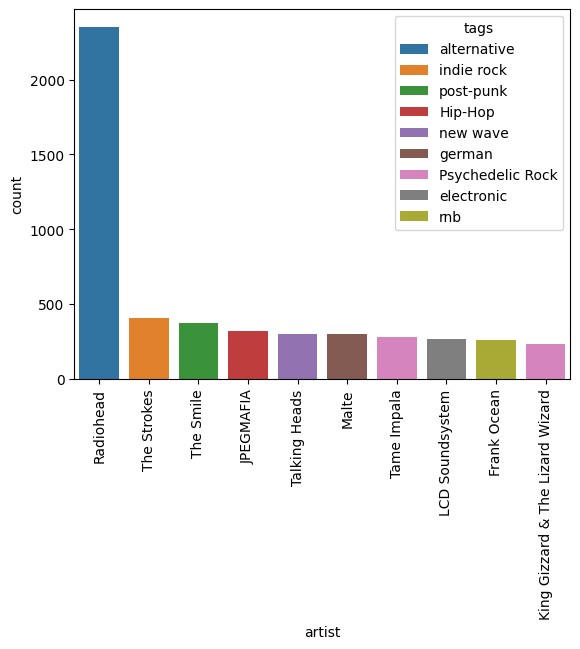

In [135]:
sns.barplot(top_10_artists, x='artist', y='count', hue='tags');
plt.xticks(rotation=90);

In [136]:
df['date_listened'] = pd.to_datetime(df['date_listened'])

In [137]:
df

,track_name,artist,album_name,date_listened,uts,url,tags
0,Untouched,SilenCee,Untouched,2022-12-07 09:30:00,1670405412,https://www.last.fm/music/SilenCee/_/Untouched,electronic
1,maria,Malte,maria,2022-12-07 09:18:00,1670404731,https://www.last.fm/music/Malte/_/maria,german
2,let me go,Malte,let me go,2022-12-07 09:16:00,1670404596,https://www.last.fm/music/Malte/_/let+me+go,german
3,So What,mqx,So What,2022-12-07 09:14:00,1670404473,https://www.last.fm/music/mqx/_/So+What,hardstyle
4,maria,Malte,maria,2022-12-07 09:11:00,1670404288,https://www.last.fm/music/Malte/_/maria,german
...,...,...,...,...,...,...,...
17686,The Tower,Future Islands,People Who Aren’t There Anymore,2024-07-17 12:51:00,1721220684,https://www.last.fm/music/Future+Islands/_/The...,seen live
17687,King of Sweden,Future Islands,People Who Aren’t There Anymore,2024-07-17 12:47:00,1721220434,https://www.last.fm/music/Future+Islands/_/Kin...,seen live
17688,Svefn-g-englar,Sigur Rós,Ágætis byrjun,2024-07-17 12:41:00,1721220115,https://www.last.fm/music/Sigur+R%C3%B3s/_/Sve...,post-rock
17689,Svefn-g-englar,Sigur Rós,Ágætis byrjun,2024-07-17 11:46:00,1721216760,https://www.last.fm/music/Sigur+R%C3%B3s/_/Sve...,post-rock


In [138]:
df.set_index('date_listened', inplace=True)

In [139]:
df

,track_name,artist,album_name,uts,url,tags
date_listened,,,,,,
2022-12-07 09:30:00,Untouched,SilenCee,Untouched,1670405412,https://www.last.fm/music/SilenCee/_/Untouched,electronic
2022-12-07 09:18:00,maria,Malte,maria,1670404731,https://www.last.fm/music/Malte/_/maria,german
2022-12-07 09:16:00,let me go,Malte,let me go,1670404596,https://www.last.fm/music/Malte/_/let+me+go,german
2022-12-07 09:14:00,So What,mqx,So What,1670404473,https://www.last.fm/music/mqx/_/So+What,hardstyle
2022-12-07 09:11:00,maria,Malte,maria,1670404288,https://www.last.fm/music/Malte/_/maria,german
...,...,...,...,...,...,...
2024-07-17 12:51:00,The Tower,Future Islands,People Who Aren’t There Anymore,1721220684,https://www.last.fm/music/Future+Islands/_/The...,seen live
2024-07-17 12:47:00,King of Sweden,Future Islands,People Who Aren’t There Anymore,1721220434,https://www.last.fm/music/Future+Islands/_/Kin...,seen live
2024-07-17 12:41:00,Svefn-g-englar,Sigur Rós,Ágætis byrjun,1721220115,https://www.last.fm/music/Sigur+R%C3%B3s/_/Sve...,post-rock


In [140]:
monthly_counts = df['track_name'].resample('M').count()

monthly_counts = monthly_counts.reset_index()

C:\Users\jiyon\AppData\Local\Temp\ipykernel_16864\1164735645.py:1: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_counts = df['track_name'].resample('M').count()


<Axes: xlabel='date_listened', ylabel='track_name'>

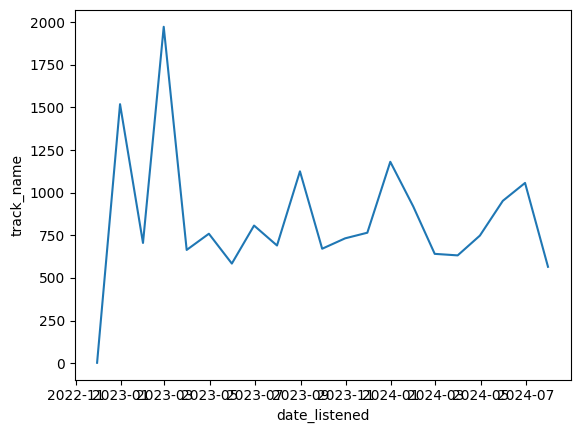

In [142]:
sns.lineplot(data=monthly_counts, x='date_listened', y='track_name')